In [ ]:
#!pip3 install sphfile pydub librosa nltk numpy matplotlib scipy sklearn hmmlearn simplejson eyed3 google-cloud pyAudioAnalysis

# Entendimeinto de la estructura del Corpus

In [4]:
from sphfile import SPHFile

sph =SPHFile('./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0167M_14ANG_31DIC12.sph') #0330F_14ANG_31DIC12.sph
# Note that the following loads the whole file into ram
print( sph.format )
# write out a wav file with content from 111.29 to 123.57 seconds
sph.write_wav('test01.wav')

{'sample_rate': 16000, 'channel_count': 1, 'sample_byte_format': '01', 'sample_n_bytes': 2, 'sample_sig_bits': 16, 'sample_coding': 'pcm'}


'test01.wav'

(65111,)
22050


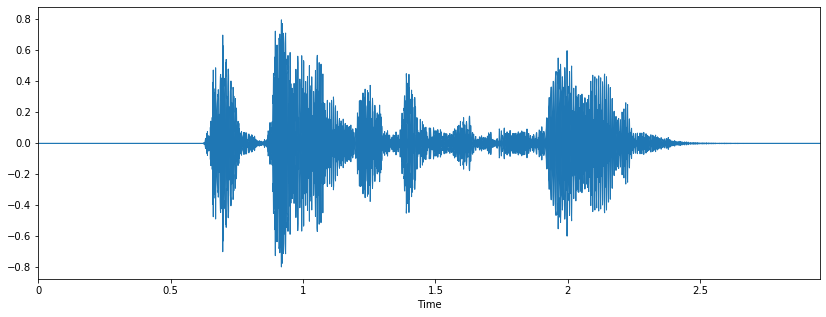

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

x, sr = librosa.load('./test01.wav')
print(x.shape)
print(sr)

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

In [6]:
import IPython.display as ipd

ipd.Audio('./test01.wav')

In [7]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

sound_file = AudioSegment.from_wav("./test01.wav")
audio_chunks = split_on_silence(sound_file, 
    # must be silent for at least 1/8 of a second 'utt_cnt',
    min_silence_len=125,

    # consider it silent if quieter than -16 dBFS
    silence_thresh=-16
)

for i, chunk in enumerate(audio_chunks):
    out_file = "./chunk{0}.wav".format(i)
    print("exporting", out_file)
    chunk.export(out_file, format="wav")

exporting ./chunk0.wav
exporting ./chunk1.wav


In [8]:
ipd.Audio('./chunk0.wav')

# Training data

In [3]:
import pandas as pd
import numpy as np
import os
from nltk.tag import hmm

In [10]:
folders = os.listdir('./Corpus/CIEMPIESS_SPH/train/')

dataset = []
for folder in folders:
    for files in os.walk('./Corpus/CIEMPIESS_SPH/train/'+folder):
        for file in files[2]:
            sph =SPHFile(files[0]+'/'+file)
            dataset.append([files[0]+'/'+file,file[:-4],'',0,None ])

In [11]:
data = pd.DataFrame(dataset)
data.columns = ['pwd','audioID', 'transcription', 'utt_cnt', 'utterances']
data.head()

,pwd,audioID,transcription,utt_cnt,utterances
0,./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0167M...,0167M_14ANG_31DIC12,,0,None
1,./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0330F...,0330F_14ANG_31DIC12,,0,None
2,./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0260M...,0260M_14ANG_31DIC12,,0,None
3,./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0375M...,0375M_14ANG_31DIC12,,0,None
4,./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0001F...,0001F_14ANG_31DIC12,,0,None


In [12]:
def get_utterances(text):
    l = text.split(' ')
    l = [w for w in l if w[0] != '<']
    l = [w for w in l if w[0:2] != '++']
    return [len(l),l]

In [13]:
with open('./Corpus/CIEMPIESS_SPH/transcriptions/CIEMPIESS_train.transcription') as fp:
    dataset = np.array(dataset)
    tmp = dataset[:,1]
    for cnt, line in enumerate(fp):
        fileId = line[len(line)-21:-2]
        fileTrans = line[:-23]
        for idx, d in enumerate(tmp):
            if d == fileId:
                dataset[idx, 2] = fileTrans
                utt = get_utterances(fileTrans)
                dataset[idx, 3] = utt[0]
                dataset[idx, 4] = utt[1]

In [14]:
data = pd.DataFrame(dataset)
pd.DataFrame(dataset).to_csv("./csv_files/lm_train.csv")
data.columns = ['pwd','audioID', 'transcription', 'utt_cnt', 'utterances']
data.head()

,pwd,audioID,transcription,utt_cnt,utterances
0,./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0167M...,0167M_14ANG_31DIC12,<s> <sil> tratAdos internacionAles <sil> </s>,2,"[tratAdos, internacionAles]"
1,./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0330F...,0330F_14ANG_31DIC12,<s> <sil> pEro En El tEma concrEto dEl hOy En ...,15,"[pEro, En, El, tEma, concrEto, dEl, hOy, En, d..."
2,./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0260M...,0260M_14ANG_31DIC12,<s> <sil> dE derEcho internacionAl <sil> </s>,3,"[dE, derEcho, internacionAl]"
3,./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0375M...,0375M_14ANG_31DIC12,<s> <sil> y quE quiEre decIr dE constitucional...,6,"[y, quE, quiEre, decIr, dE, constitucionalidAd]"
4,./Corpus/CIEMPIESS_SPH/train/14ANG_TRAIN/0001F...,0001F_14ANG_31DIC12,<s> <sil> hOla quE tAl mUy buEnas tArdes <sil>...,6,"[hOla, quE, tAl, mUy, buEnas, tArdes]"


In [1]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction

#for d in dataset:
#    filepath = d[0]
#    fileId = d[1]
#    try:
#        sph = SPHFile(filepath)
#        new_file = './wav_files/'+fileId+'.wav'
#        sph.write_wav(new_file)
#    except:
#        pass

In [15]:
wavs = os.listdir('./wav_files')

datawav = []
for w in wavs: 
    try:
        [Fs, x] = audioBasicIO.readAudioFile('./wav_files/'+w)
        F, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.050*Fs, 0.025*Fs)
        data = []
        for idx, fi in enumerate(F):
            fi = np.mean(np.array(fi))
            data.append(fi)
        datawav.append(data)
    except:
        pass

Error: file not found or other I/O error. (DECODING FAILED)


In [17]:
xdata = pd.DataFrame(datawav)

pd.DataFrame(datawav).to_csv("./csv_files/Xtrain_mean.csv")
xdata.columns = ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std']
xdata.head()

,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,mfcc_2,...,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,chroma_std
0,0.073431,0.031929,2.939388,0.140115,0.175640,0.381022,0.014379,0.105812,-26.989509,3.530759,...,0.010604,0.006790,0.013128,0.013074,0.007105,0.004707,0.012541,0.024918,0.024101,0.029263
1,0.063457,0.020282,3.020116,0.145139,0.188987,0.384518,0.011321,0.090633,-26.947274,3.329940,...,0.010647,0.019760,0.017187,0.048600,0.003814,0.008895,0.017943,0.038742,0.012691,0.026973
2,0.161297,0.029031,2.871945,0.248034,0.225213,0.692359,0.008201,0.231096,-27.171415,3.550021,...,0.021276,0.028206,0.013316,0.035163,0.002655,0.006359,0.008963,0.011138,0.008768,0.021705
3,0.151151,0.032016,2.974693,0.246841,0.215434,0.832078,0.008935,0.234722,-27.369234,2.658317,...,0.011025,0.022351,0.013260,0.034631,0.005009,0.007154,0.016049,0.024778,0.008578,0.024683
4,0.067691,0.049090,2.966902,0.152815,0.206874,0.215715,0.015303,0.100890,-27.287749,3.891584,...,0.005092,0.017491,0.008848,0.020636,0.000336,0.013539,0.061257,0.031941,0.007896,0.025077


In [18]:
wavs_test = os.listdir('./wav_test')

datawavtest = []
for w in wavs_test: 
    try:
        [Fs, x] = audioBasicIO.readAudioFile('./wav_test/'+w)
        F, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.050*Fs, 0.025*Fs)
        data = []
        for idx, fi in enumerate(F):
            fi = np.mean(np.array(fi))
            data.append(fi)
        datawavtest.append(data)
    except:
        pass

In [22]:
xdatat = pd.DataFrame(datawavtest)

pd.DataFrame(datawavtest).to_csv("./csv_files/Xtest_mean.csv")
xdatat.columns = ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std']
xdatat.head()

,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,mfcc_2,...,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,chroma_std
0,0.256303,0.036882,2.958497,0.288992,0.175287,0.839641,0.010454,0.282054,-29.891255,1.60097,...,0.006879,0.012786,0.017562,0.01805,0.002,0.00516,0.006073,0.009979,0.015785,0.024205
1,0.256303,0.036882,2.958497,0.288992,0.175287,0.839641,0.010454,0.282054,-29.891255,1.60097,...,0.006879,0.012786,0.017562,0.01805,0.002,0.00516,0.006073,0.009979,0.015785,0.024205
2,0.256303,0.036882,2.958497,0.288992,0.175287,0.839641,0.010454,0.282054,-29.891255,1.60097,...,0.006879,0.012786,0.017562,0.01805,0.002,0.00516,0.006073,0.009979,0.015785,0.024205
3,0.256303,0.036882,2.958497,0.288992,0.175287,0.839641,0.010454,0.282054,-29.891255,1.60097,...,0.006879,0.012786,0.017562,0.01805,0.002,0.00516,0.006073,0.009979,0.015785,0.024205
4,0.256303,0.036882,2.958497,0.288992,0.175287,0.839641,0.010454,0.282054,-29.891255,1.60097,...,0.006879,0.012786,0.017562,0.01805,0.002,0.00516,0.006073,0.009979,0.015785,0.024205


In [60]:
files = os.listdir('./Corpus/CIEMPIESS_SPH/test/ciempiess')

dataset = []
for file in files:
    sph =SPHFile('./Corpus/CIEMPIESS_SPH/test/ciempiess/'+file)
    dataset.append(['./Corpus/CIEMPIESS_SPH/test/ciempiess/'+file,file[:-4],'',0,None ])          

In [61]:
print(len(dataset))
with open('./Corpus/CIEMPIESS_SPH/transcriptions/CIEMPIESS_test.transcription') as fp:
    dataset = np.array(dataset)
    tmp = dataset[:,1]
    for cnt, line in enumerate(fp):
        fileId = line[len(line)-21:-2]
        fileTrans = line[:-23]
        for idx, d in enumerate(tmp):
            if d == fileId:
                dataset[idx, 2] = fileTrans
                utt = get_utterances(fileTrans)
                dataset[idx, 3] = utt[0]
                dataset[idx, 4] = utt[1]

700


In [62]:
data = pd.DataFrame(dataset)
pd.DataFrame(dataset).to_csv("./csv_files/lm_test.csv")
data.columns = ['pwd','audioID', 'transcription', 'utt_cnt', 'utterances']
print(len(data))
data.head()

700


,pwd,audioID,transcription,utt_cnt,utterances
0,./Corpus/CIEMPIESS_SPH/test/ciempiess/0283M_04...,0283M_04ANG_17SEP12,<s> En El </s>,2,"[En, El]"
1,./Corpus/CIEMPIESS_SPH/test/ciempiess/0208M_04...,0208M_04ANG_17SEP12,<s> pEro </s>,1,[pEro]
2,./Corpus/CIEMPIESS_SPH/test/ciempiess/0236M_02...,0236M_02ANG_27AGO12,<s> posesiOn sImple </s>,2,"[posesiOn, sImple]"
3,./Corpus/CIEMPIESS_SPH/test/ciempiess/0156M_12...,0156M_12ANG_17DIC12,<s> Es </s>,1,[Es]
4,./Corpus/CIEMPIESS_SPH/test/ciempiess/0382M_02...,0382M_02ANG_27AGO12,<s> pAra quE puEdan </s>,3,"[pAra, quE, puEdan]"


In [65]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction

for d in dataset:
    filepath = d[0]
    fileId = d[1]
    try:
        new_file = './wav_test/'+fileId+'.wav'
        sph.write_wav(new_file)
    except:
        pass

In [66]:
wavs = os.listdir('./wav_test')

datawav = []
for w in wavs: 
    try:
        [Fs, x] = audioBasicIO.readAudioFile('./wav_test/'+w)
        F, f_names = audioFeatureExtraction.stFeatureExtraction(x, Fs, 0.050*Fs, 0.025*Fs)
        datawav.append([fileId, F[0], F[1], F[2], F[3], F[4], F[5], F[6], F[7], F[8], F[9], F[10], F[11], F[12], F[13], F[14], F[15], F[16], F[17], F[18], F[19],F[20], F[21], F[22], F[23], F[24], F[25], F[26], F[27], F[28], F[29], F[30], F[31], F[32], F[33]])
    except:
        pass

In [70]:
tdata = pd.DataFrame(datawav)

pd.DataFrame(datawav).to_csv("./csv_files/am_test.csv")
tdata.columns = ['fileId','zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std']
tdata.head()

,fileId,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,...,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,chroma_std
0,0112F_09ANG_22OCT12,"[0.7571964956195244, 0.7196495619524406, 0.659...","[6.164203210903245e-09, 6.39096237163341e-09, ...","[3.2627055470769326, 3.2411475470738624, 3.141...","[0.7811371012955293, 0.7806546622985656, 0.680...","[0.19496880070628442, 0.20768376053266654, 0.3...","[1.466218604012181, 1.4894614903323071, 1.7895...","[0.0, 0.0023412750892823635, 0.003752325564247...","[0.7275, 0.74, 0.7175, 0.35, 0.165, 0.205, 0.2...","[-48.705606875049305, -48.72632822106662, -46....",...,"[2.418582544588166e-05, 2.7067527927806733e-05...","[2.178238766529599e-05, 4.2050007411683835e-05...","[7.243881748443754e-05, 3.213235164385605e-05,...","[0.00023311696902209838, 0.0007128702908590548...","[0.0003003223452474261, 0.00016804274625197832...","[0.0005690906404583965, 0.0002783604982494583,...","[0.0027408078842486128, 0.0008333959294831958,...","[0.0017144681712159891, 0.0011401692452507333,...","[0.00253961969575853, 0.0020782570225466182, 0...","[0.0009501083554428813, 0.0006842081452417037,..."
1,0112F_09ANG_22OCT12,"[0.7571964956195244, 0.7196495619524406, 0.659...","[6.164203210903245e-09, 6.39096237163341e-09, ...","[3.2627055470769326, 3.2411475470738624, 3.141...","[0.7811371012955293, 0.7806546622985656, 0.680...","[0.19496880070628442, 0.20768376053266654, 0.3...","[1.466218604012181, 1.4894614903323071, 1.7895...","[0.0, 0.0023412750892823635, 0.003752325564247...","[0.7275, 0.74, 0.7175, 0.35, 0.165, 0.205, 0.2...","[-48.705606875049305, -48.72632822106662, -46....",...,"[2.418582544588166e-05, 2.7067527927806733e-05...","[2.178238766529599e-05, 4.2050007411683835e-05...","[7.243881748443754e-05, 3.213235164385605e-05,...","[0.00023311696902209838, 0.0007128702908590548...","[0.0003003223452474261, 0.00016804274625197832...","[0.0005690906404583965, 0.0002783604982494583,...","[0.0027408078842486128, 0.0008333959294831958,...","[0.0017144681712159891, 0.0011401692452507333,...","[0.00253961969575853, 0.0020782570225466182, 0...","[0.0009501083554428813, 0.0006842081452417037,..."
2,0112F_09ANG_22OCT12,"[0.7571964956195244, 0.7196495619524406, 0.659...","[6.164203210903245e-09, 6.39096237163341e-09, ...","[3.2627055470769326, 3.2411475470738624, 3.141...","[0.7811371012955293, 0.7806546622985656, 0.680...","[0.19496880070628442, 0.20768376053266654, 0.3...","[1.466218604012181, 1.4894614903323071, 1.7895...","[0.0, 0.0023412750892823635, 0.003752325564247...","[0.7275, 0.74, 0.7175, 0.35, 0.165, 0.205, 0.2...","[-48.705606875049305, -48.72632822106662, -46....",...,"[2.418582544588166e-05, 2.7067527927806733e-05...","[2.178238766529599e-05, 4.2050007411683835e-05...","[7.243881748443754e-05, 3.213235164385605e-05,...","[0.00023311696902209838, 0.0007128702908590548...","[0.0003003223452474261, 0.00016804274625197832...","[0.0005690906404583965, 0.0002783604982494583,...","[0.0027408078842486128, 0.0008333959294831958,...","[0.0017144681712159891, 0.0011401692452507333,...","[0.00253961969575853, 0.0020782570225466182, 0...","[0.0009501083554428813, 0.0006842081452417037,..."
3,0112F_09ANG_22OCT12,"[0.7571964956195244, 0.7196495619524406, 0.659...","[6.164203210903245e-09, 6.39096237163341e-09, ...","[3.2627055470769326, 3.2411475470738624, 3.141...","[0.7811371012955293, 0.7806546622985656, 0.680...","[0.19496880070628442, 0.20768376053266654, 0.3...","[1.466218604012181, 1.4894614903323071, 1.7895...","[0.0, 0.0023412750892823635, 0.003752325564247...","[0.7275, 0.74, 0.7175, 0.35, 0.165, 0.205, 0.2...","[-48.705606875049305, -48.72632822106662, -46....",...,"[2.418582544588166e-05, 2.7067527927806733e-05...","[2.178238766529599e-05, 4.2050007411683835e-05...","[7.243881748443754e-05, 3.213235164385605e-05,...","[0.00023311696902209838, 0.0007128702908590548...","[0.0003003223452474261, 0.0001680

In [93]:
x_test = pd.read_csv("./csv_files/X_test.csv")   
x_test.drop(["0"], axis = 1, inplace = True)
x_test.columns = ['fileId','zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std']
x_test.drop(["fileId"], axis = 1, inplace = True)
x_test.to_csv(r'./csv_files/X_test_data.csv', index=False, header=False)
x_test.head()

,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,mfcc_2,...,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,chroma_std
0,[0.7571965 0.71964956 0.65957447 0.39674593 0...,[6.16420321e-09 6.39096237e-09 8.37384799e-09 ...,[3.26270555 3.24114755 3.14121712 1.63307043 0...,[0.7811371 0.78065466 0.68053092 0.24766099 0...,[0.1949688 0.20768376 0.31890787 0.28843832 0...,[1.4662186 1.48946149 1.78953711 0.91303182 1...,[0. 0.00234128 0.00375233 0.01059369 0...,[0.7275 0.74 0.7175 0.35 0.165 0.205 0.2...,[-48.70560688 -48.72632822 -46.72693106 -38.06...,[-0.50318942 -0.26810336 1.14121475 1.933609...,...,[2.41858254e-05 2.70675279e-05 2.46953133e-04 ...,[2.17823877e-05 4.20500074e-05 7.92530655e-04 ...,[7.24388175e-05 3.21323516e-05 1.72909390e-04 ...,[2.33116969e-04 7.12870291e-04 6.51362643e-02 ...,[3.00322345e-04 1.68042746e-04 7.43695894e-05 ...,[5.69090640e-04 2.78360498e-04 4.66609486e-04 ...,[2.74080788e-03 8.33395929e-04 6.78344797e-04 ...,[1.71446817e-03 1.14016925e-03 2.00108454e-02 ...,[2.53961970e-03 2.07825702e-03 6.14762096e-04 ...,[0.00095011 0.00068421 0.01823242 0.03154883 0...
1,[0.7571965 0.71964956 0.65957447 0.39674593 0...,[6.16420321e-09 6.39096237e-09 8.37384799e-09 ...,[3.26270555 3.24114755 3.14121712 1.63307043 0...,[0.7811371 0.78065466 0.68053092 0.24766099 0...,[0.1949688 0.20768376 0.31890787 0.28843832 0...,[1.4662186 1.48946149 1.78953711 0.91303182 1...,[0. 0.00234128 0.00375233 0.01059369 0...,[0.7275 0.74 0.7175 0.35 0.165 0.205 0.2...,[-48.70560688 -48.72632822 -46.72693106 -38.06...,[-0.50318942 -0.26810336 1.14121475 1.933609...,...,[2.41858254e-05 2.70675279e-05 2.46953133e-04 ...,[2.17823877e-05 4.20500074e-05 7.92530655e-04 ...,[7.24388175e-05 3.21323516e-05 1.72909390e-04 ...,[2.33116969e-04 7.12870291e-04 6.51362643e-02 ...,[3.00322345e-04 1.68042746e-04 7.43695894e-05 ...,[5.69090640e-04 2.78360498e-04 4.66609486e-04 ...,[2.74080788e-03 8.33395929e-04 6.78344797e-04 ...,[1.71446817e-03 1.14016925e-03 2.00108454e-02 ...,[2.53961970e-03 2.07825702e-03 6.14762096e-04 ...,[0.00095011 0.00068421 0.01823242 0.03154883 0...
2,[0.7571965 0.71964956 0.65957447 0.39674593 0...,[6.16420321e-09 6.39096237e-09 8.37384799e-09 ...,[3.26270555 3.24114755 3.14121712 1.63307043 0...,[0.7811371 0.78065466 0.68053092 0.24766099 0...,[0.1949688 0.20768376 0.31890787 0.28843832 0...,[1.4662186 1.48946149 1.78953711 0.91303182 1...,[0. 0.00234128 0.00375233 0.01059369 0...,[0.7275 0.74 0.7175 0.35 0.165 0.205 0.2...,[-48.70560688 -48.72632822 -46.72693106 -38.06...,[-0.50318942 -0.26810336 1.14121475 1.933609...,...,[2.41858254e-05 2.70675279e-05 2.46953133e-04 ...,[2.17823877e-05 4.20500074e-05 7.92530655e-04 ...,[7.24388175e-05 3.21323516e-05 1.72909390e-04 ...,[2.33116969e-04 7.12870291e-04 6.51362643e-02 ...,[3.00322345e-04 1.68042746e-04 7.43695894e-05 ...,[5.69090640e-04 2.78360498e-04 4.66609486e-04 ...,[2.74080788e-03 8.33395929e-04 6.78344797e-04 ...,[1.71446817e-03 1.14016925e-03 2.00108454e-02 ...,[2.53961970e-03 2.07825702e-03 6.14762096e-04 ...,[0.00095011 0.00068421 0.01823242 0.03154883 0...
3,[0.7571965 0.71964956 0.65957447 0.39674593 0...,[6.16420321e-09 6.39096237e-09 8.37384799e-09 ...,[3.26270555 3.24114755 3.14121712 1.63307043 0...,[0.7811371 0.78065466 0.68053092 0.24766099 0...,[0.1949688 0.20768376 0.31890787 0.28843832 0...,[1.4662186 1.48946149 1.78953711 0.91303182 1...,[0. 0.00234128 0.00375233 0.01059369 0...,[0.7275 0.74 0.7175 0.35 0.165 0.205 0.2...,[-48.70560688 -48.72632822 -46.72693106 -38.06...,[-0.50318942 -0.26810336 1.14121475 1.933609...,...,[2.41858254e-05 2.70675279e-05 2.46953133e-04 ...,[2.17823877e-05 4.20500074e-05 7.92530655e-04 ...,[7.24388175e-05 3.21323516e-05 1.72909390e-04 ...,[2.33116969e-04 7.12870291e-04 6.51362643e-02 ...,[3.00322345e-04 1.68042746e-04 7.43695894e-05 ...,[5.69090640e-04 2.78360498e-04 4.66609486e-04 ...,[2.74080788e-03 8.33395929e-04 6.7

In [20]:
mylist = []

for chunk in  pd.read_csv('./csv_files/X_train.csv', sep=',', chunksize=20000):
    mylist.append(chunk)

big_data = pd.concat(mylist, axis= 0)
del mylist

In [21]:
x_train = big_data
x_train.columns = ['file','fileId','zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std']
x_train.drop(['file','fileId'], axis = 1, inplace = True)
x_train.to_csv(r'./csv_files/X_train_data.csv', index=False, header=False)
x_train.head()

,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,mfcc_2,...,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,chroma_std
0,[0.5456821 0.58698373 0.56070088 0.56195244 0...,[2.91399540e-07 9.42621485e-08 5.82941293e-08 ...,[2.85861749 3.11068207 3.22216166 3.17256746 3...,[0.5561912 0.56978815 0.55879598 0.55373905 0...,[0.26456275 0.30020619 0.31558258 0.32191867 0...,[1.38061523 1.62937599 2.03125976 2.27719379 2...,[0. 0.00571664 0.00412775 0.00248307 0...,[0.6675 0.67 0.6725 0.6875 0.795 0.06 0.3...,[-42.61624732 -42.85241547 -43.02703318 -42.80...,[-0.32807129 0.22480078 0.45178244 0.400597...,...,[1.41352195e-04 1.01866563e-04 8.96990172e-05 ...,[0.00018464 0.00042978 0.00111862 0.001124 0...,[9.53286291e-05 3.46454520e-04 4.65190780e-04 ...,[0.00222447 0.00235784 0.01587252 0.00857868 0...,[4.52969394e-04 1.63138226e-03 3.40864795e-04 ...,[0.00010713 0.00034843 0.00026413 0.00039892 0...,[0.02759096 0.01294438 0.01906264 0.0133273 0...,[0.00146311 0.00419266 0.01501057 0.03203356 0...,[2.18593598e-04 3.77366107e-05 6.10568364e-04 ...,[0.00750851 0.00344136 0.00693507 0.00893876 0...
1,[0.57697121 0.5494368 0.62202753 0.51314143 0...,[2.18488400e-05 1.00632817e-05 2.95531008e-06 ...,[3.16999951 3.06583291 2.33333559 2.32083841 0...,[0.61217499 0.60339687 0.60388222 0.45609733 0...,[0.18288592 0.19894819 0.21238211 0.35139785 0...,[2.34196054 2.38299652 2.39793261 1.55939408 0...,[0. 0.00282929 0.00283159 0.01140984 0...,[0.8175 0.82 0.8175 0.8725 0.075 0.0675 0.5...,[-42.56712807 -41.07762255 -42.93809337 -38.40...,[-3.04514745 -1.59742911 -0.4867834 1.877786...,...,[8.72070862e-05 1.94404018e-05 1.07233119e-05 ...,[2.05976387e-03 6.68028835e-04 4.92924465e-05 ...,[0.009597 0.00383069 0.00594808 0.00906029 0...,[8.82839567e-05 3.17963501e-04 6.29192302e-05 ...,[0.00046164 0.00130358 0.00263474 0.00099093 0...,[0.00379022 0.00222025 0.0002102 0.00319545 0...,[5.39366011e-05 1.54725085e-04 1.71622936e-04 ...,[0.00245822 0.00612396 0.00311983 0.01092146 0...,[0.00143433 0.0010072 0.00075101 0.02676476 0...,[0.00266162 0.00180922 0.00178255 0.01177141 0...
2,[0.1339174 0.19774718 0.38923655 0.41051314 0...,[1.27394986e-04 1.40279125e-04 1.88043485e-04 ...,[3.10843754 3.13928893 3.17917522 1.54629327 2...,[0.27476072 0.4049637 0.51723447 0.30747824 0...,[0.2805172 0.34213269 0.33546645 0.30951613 0...,[0.84774391 1.45979499 2.6201219 1.29341744 0...,[0. 0.00252435 0.00362146 0.00452156 0...,[0.215 0.8725 0.9375 0.165 0.1575 0.19 0.2...,[-30.40587135 -30.47969834 -29.97609454 -25.97...,[ 1.99392516 1.83567792 1.41199658 1.775685...,...,[0.00480162 0.00471116 0.00529402 0.02375982 0...,[0.01329838 0.00638789 0.00771432 0.02440801 0...,[3.40328259e-03 3.04905177e-03 4.80896671e-03 ...,[0.00563695 0.00689631 0.00403231 0.01550762 0...,[3.25132121e-04 5.44270260e-04 1.33516835e-03 ...,[0.00066869 0.00376871 0.00272826 0.00556952 0...,[6.32481393e-03 4.71534670e-03 2.37604087e-03 ...,[1.62065104e-02 5.58883113e-03 9.62744170e-03 ...,[0.00098402 0.00092105 0.00721792 0.00367965 0...,[0.02398127 0.02542393 0.00659114 0.00873809 0...
3,[0.0738423 0.02753442 0.06257822 0.14267835 0...,[1.33452741e-04 2.24112992e-04 1.05575712e-04 ...,[2.02063775 2.63651464 1.94779494 2.55314098 3...,[0.12824476 0.1125756 0.11256359 0.18923381 0...,[0.19531955 0.18942813 0.20029984 0.21932194 0...,[0.1914257 0.07487959 0.08190838 0.85496485 1...,[0. 0.03997364 0.04692877 0.03962067 0...,[0.005 0.005 0.005 0.225 0.235 0.2325 0.2...,[-33.15653903 -34.31405554 -35.59063252 -36.41...,[ 1.58706663 1.66024119 1.23409214 1.181184...,...,[1.25722707e-04 1.17843649e-03 3.72451857e-05 ...,[0.00280759 0.00056653 0.0006816 0.00260051 0...,[1.50332515e-04 1.55195516e-04 5.78153326e-05 ...,[0.26990493 0.46381111 0.25507097 0.17719493 0...,[7.80929695e-05 4.97409804e-05 3.31651229e-05 ...,[4.06329375e-04 4.14817767e-05 2.59682792e-05 ...,[5.93530055e-04 3.76018582e-04 1

In [37]:
y_test = pd.read_csv("./csv_files/Y_test.csv")   
y_test.columns = ['id','pwd', 'file', 'transcription', 'n_utt', 'utterances']
y_test.drop(['id','pwd', 'file','n_utt', 'utterances'], axis = 1, inplace = True)
y_test.to_csv(r'./csv_files/y_test_data_trans.csv', index=False)
y_test.head()

,transcription
0,<s> En El </s>
1,<s> pEro </s>
2,<s> posesiOn sImple </s>
3,<s> Es </s>
4,<s> pAra quE puEdan </s>


In [25]:
y_test = pd.read_csv("./csv_files/Y_test.csv")   
y_test.columns = ['id','pwd', 'file', 'transcription', 'n_utt', 'utterances']
y_test.drop(['id','pwd', 'file','transcription', 'utterances'], axis = 1, inplace = True)
y_test.to_csv(r'./csv_files/y_test_data_nutt.csv', index=False, header=False)
y_test.head()

,n_utt
0,2
1,1
2,2
3,1
4,3


In [15]:
y_test = pd.read_csv("./csv_files/Y_test.csv")   
y_test.columns = ['id','pwd', 'file', 'transcription', 'n_utt', 'utterances']
y_test.drop(['id','pwd', 'file','transcription', 'n_utt'], axis = 1, inplace = True)
y_test.to_csv(r'./csv_files/y_test_data_utt.csv', index=False, header=False)
y_test.head()

,utterances
0,"['En', 'El']"
1,['pEro']
2,"['posesiOn', 'sImple']"
3,['Es']
4,"['pAra', 'quE', 'puEdan']"


In [29]:
!ls ./csv_files/

am_test.csv   X_test.csv	Y_test.csv	       Y_train.csv
am_train.csv  X_test_data.csv	y_test_data_nutt.csv   y_train_data_nutt.csv
lm_test.csv   X_train.csv	y_test_data_trans.csv  y_train_data_trans.csv
lm_train.csv  X_train_data.csv	y_test_data_utt.csv    y_train_data_utt.csv


In [32]:
y_test = pd.read_csv("./csv_files/Y_train.csv")   
y_test.columns = ['id','pwd', 'file', 'transcription', 'n_utt', 'utterances']
y_test.drop(['id','pwd', 'file','n_utt', 'utterances'], axis = 1, inplace = True)
y_test.to_csv(r'./csv_files/y_train_data_trans.csv', index=False)
y_test.head()

,transcription
0,<s> <sil> tratAdos internacionAles <sil> </s>
1,<s> <sil> pEro En El tEma concrEto dEl hOy En ...
2,<s> <sil> dE derEcho internacionAl <sil> </s>
3,<s> <sil> y quE quiEre decIr dE constitucional...
4,<s> <sil> hOla quE tAl mUy buEnas tArdes <sil>...


In [27]:
y_test = pd.read_csv("./csv_files/Y_train.csv")   
y_test.columns = ['id','pwd', 'file', 'transcription', 'n_utt', 'utterances']
y_test.drop(['id','pwd', 'file','transcription', 'utterances'], axis = 1, inplace = True)
y_test.to_csv(r'./csv_files/y_train_data_nutt.csv', index=False, header=False)
y_test.head()

,n_utt
0,2
1,15
2,3
3,6
4,6


In [28]:
y_test = pd.read_csv("./csv_files/Y_train.csv")   
y_test.columns = ['id','pwd', 'file', 'transcription', 'n_utt', 'utterances']
y_test.drop(['id','pwd', 'file','transcription', 'n_utt'], axis = 1, inplace = True)
y_test.to_csv(r'./csv_files/y_train_data_utt.csv', index=False, header=False)
y_test.head()

,utterances
0,"['tratAdos', 'internacionAles']"
1,"['pEro', 'En', 'El', 'tEma', 'concrEto', 'dEl'..."
2,"['dE', 'derEcho', 'internacionAl']"
3,"['y', 'quE', 'quiEre', 'decIr', 'dE', 'constit..."
4,"['hOla', 'quE', 'tAl', 'mUy', 'buEnas', 'tArdes']"


In [74]:
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from sklearn import preprocessing
from keras.layers import Activation, LSTM, Dense
from sklearn.model_selection import train_test_split

In [163]:
min_max_scaler = preprocessing.MinMaxScaler()
Xtrain = pd.read_csv("./csv_files/Xtrain_mean.csv")
Xtrain = min_max_scaler.fit_transform(Xtrain)
Xtrain = pd.DataFrame(Xtrain)
Ytrain = pd.read_csv("./csv_files/y_train_data_nutt.csv")
Ytrain = min_max_scaler.fit_transform(Ytrain)
Ytrain = pd.DataFrame(Ytrain)
Xtest = pd.read_csv("./csv_files/Xtest_mean.csv")
Xtest = min_max_scaler.fit_transform(Xtest)
Xtest = pd.DataFrame(Xtest)
Ytest = pd.read_csv("./csv_files/y_test_data_nutt.csv")
Ytest = min_max_scaler.fit_transform(Ytest)
Ytest = pd.DataFrame(Ytest)

In [127]:
classifier = Sequential() # Initialising the ANN
classifier.add(Dense(units = 28, input_dim = 35))
classifier.add(Dense(units = 28))
classifier.add(Dense(units = 16))
classifier.add(Dense(units = 16))
classifier.add(Dense(units = 8))
classifier.add(Dense(units = 8))
classifier.add(Dense(units = 6))
classifier.add(Dense(units = 1))

In [128]:
Xtest = Xtest.iloc[1:]
print(len(Xtrain),len(Ytrain))
print(len(Xtest),len(Ytest))

16718 16718
699 699


In [129]:
classifier.compile(loss='mean_squared_error', optimizer = 'Adam', metrics = ['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 28)                1008      
_________________________________________________________________
dense_95 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_96 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_97 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_98 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_99 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_100 (Dense)            (None, 6)                 54        
__________

In [130]:
classifier.fit(Xtrain, Ytrain, batch_size = 100,epochs = 382)

Epoch 1/382
16718/16718 [==============================] - 1s 54us/step - loss: 0.0038 - acc: 0.0476
Epoch 2/382
16718/16718 [==============================] - 0s 11us/step - loss: 0.0021 - acc: 0.0476
Epoch 3/382
16718/16718 [==============================] - 0s 17us/step - loss: 0.0021 - acc: 0.0476
Epoch 4/382
16718/16718 [==============================] - 0s 17us/step - loss: 0.0020 - acc: 0.0476
Epoch 5/382
16718/16718 [==============================] - 0s 25us/step - loss: 0.0020 - acc: 0.0476
Epoch 6/382
16718/16718 [==============================] - 0s 17us/step - loss: 0.0020 - acc: 0.0476
Epoch 7/382
16718/16718 [==============================] - 0s 17us/step - loss: 0.0020 - acc: 0.0476
Epoch 8/382
16718/16718 [==============================] - 0s 17us/step - loss: 0.0020 - acc: 0.0476
Epoch 9/382
16718/16718 [==============================] - 0s 13us/step - loss: 0.0020 - acc: 0.0476
Epoch 10/382
16718/16718 [==============================] - 0s 14us/step - loss: 0.0020 - a

16718/16718 [==============================] - 0s 14us/step - loss: 0.0020 - acc: 0.0476
Epoch 82/382
16718/16718 [==============================] - 0s 15us/step - loss: 0.0020 - acc: 0.0476
Epoch 83/382
16718/16718 [==============================] - 0s 16us/step - loss: 0.0020 - acc: 0.0476
Epoch 84/382
16718/16718 [==============================] - 0s 16us/step - loss: 0.0020 - acc: 0.0476
Epoch 85/382
16718/16718 [==============================] - 0s 19us/step - loss: 0.0020 - acc: 0.0476
Epoch 86/382
16718/16718 [==============================] - 0s 17us/step - loss: 0.0020 - acc: 0.0476
Epoch 87/382
16718/16718 [==============================] - 0s 14us/step - loss: 0.0020 - acc: 0.0476
Epoch 88/382
16718/16718 [==============================] - 0s 16us/step - loss: 0.0020 - acc: 0.0476
Epoch 89/382
16718/16718 [==============================] - 0s 17us/step - loss: 0.0020 - acc: 0.0476
Epoch 90/382
16718/16718 [==============================] - 0s 16us/step - loss: 0.0020 - acc: 

16718/16718 [==============================] - 0s 21us/step - loss: 0.0020 - acc: 0.0476
Epoch 161/382
16718/16718 [==============================] - 0s 13us/step - loss: 0.0020 - acc: 0.0476
Epoch 162/382
16718/16718 [==============================] - 0s 16us/step - loss: 0.0020 - acc: 0.0476
Epoch 163/382
16718/16718 [==============================] - 0s 15us/step - loss: 0.0020 - acc: 0.0476
Epoch 164/382
16718/16718 [==============================] - 0s 15us/step - loss: 0.0020 - acc: 0.0476
Epoch 165/382
16718/16718 [==============================] - 0s 16us/step - loss: 0.0020 - acc: 0.0476
Epoch 166/382
16718/16718 [==============================] - 0s 14us/step - loss: 0.0020 - acc: 0.0476
Epoch 167/382
16718/16718 [==============================] - 0s 23us/step - loss: 0.0020 - acc: 0.0476
Epoch 168/382
16718/16718 [==============================] - 0s 21us/step - loss: 0.0020 - acc: 0.0476
Epoch 169/382
16718/16718 [==============================] - 0s 19us/step - loss: 0.002

16718/16718 [==============================] - 0s 14us/step - loss: 0.0020 - acc: 0.0476
Epoch 240/382
16718/16718 [==============================] - 0s 18us/step - loss: 0.0020 - acc: 0.0476
Epoch 241/382
16718/16718 [==============================] - 0s 11us/step - loss: 0.0020 - acc: 0.0476
Epoch 242/382
16718/16718 [==============================] - 0s 13us/step - loss: 0.0020 - acc: 0.0476
Epoch 243/382
16718/16718 [==============================] - 0s 14us/step - loss: 0.0020 - acc: 0.0476
Epoch 244/382
16718/16718 [==============================] - 0s 14us/step - loss: 0.0020 - acc: 0.0476
Epoch 245/382
16718/16718 [==============================] - 0s 16us/step - loss: 0.0020 - acc: 0.0476
Epoch 246/382
16718/16718 [==============================] - 0s 18us/step - loss: 0.0020 - acc: 0.0476
Epoch 247/382
16718/16718 [==============================] - 0s 13us/step - loss: 0.0020 - acc: 0.0476
Epoch 248/382
16718/16718 [==============================] - 0s 18us/step - loss: 0.002

16718/16718 [==============================] - 0s 19us/step - loss: 0.0020 - acc: 0.0476
Epoch 319/382
16718/16718 [==============================] - 0s 19us/step - loss: 0.0020 - acc: 0.0476
Epoch 320/382
16718/16718 [==============================] - 0s 14us/step - loss: 0.0020 - acc: 0.0476
Epoch 321/382
16718/16718 [==============================] - 0s 14us/step - loss: 0.0020 - acc: 0.0476
Epoch 322/382
16718/16718 [==============================] - 0s 16us/step - loss: 0.0020 - acc: 0.0476
Epoch 323/382
16718/16718 [==============================] - 0s 17us/step - loss: 0.0020 - acc: 0.0476
Epoch 324/382
16718/16718 [==============================] - 0s 18us/step - loss: 0.0020 - acc: 0.0476
Epoch 325/382
16718/16718 [==============================] - 0s 17us/step - loss: 0.0020 - acc: 0.0476
Epoch 326/382
16718/16718 [==============================] - 0s 12us/step - loss: 0.0020 - acc: 0.0476
Epoch 327/382
16718/16718 [==============================] - 0s 17us/step - loss: 0.002

In [161]:
Y_pred = classifier.predict(Xtest)
print(len(Y_pred), Y_pred[0:10])

699 [[0.05574971]
 [0.05575787]
 [0.05576602]
 [0.05577417]
 [0.05578233]
 [0.05579048]
 [0.05579863]
 [0.05580679]
 [0.05581494]
 [0.05582309]]


In [140]:
Ytest[0:10]

,0
0,0.000000
1,0.028571
2,0.000000
3,0.057143
4,0.000000
5,0.057143
6,0.085714
7,0.000000
8,0.000000
9,0.057143
